# Análise e Histórico de Experimentos de Classificação de Categorias

Este *notebook* tem como objetivo permitir o registro visual dos experimentos feitos e oferecer um modo de recuperar um experimento e analisar os resultados em mais detalhes.
Os princípios usados para recuperar o modelo e as funções de pré-processamento usadas aqui também podem ser usadas para "produtizar" o classificador e o recomendador -- com as ressalvas já feitas anteriormente, sobre modos melhores de implementar o pipeline para o ambiente de produção e para os modos de processamento unitário ou em lote.

## Bibliotecas e Funções

In [1]:
# General
import sys
import funcy as fp
from pathlib import Path

# Visualization / Presentation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, display

import mlflow
from mlflow.tracking import MlflowClient
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix

# Carregar, além de atualizar frequentemente, código personalizado disponível em ../src
%load_ext autoreload 
%autoreload 2
sys.path.append(str(Path.cwd().parent))
from src import settings
from src.utils.notebooks import display_side_by_side
from src.utils.experiments import (set_dataset_split, 
                                   compute_multiclass_classification_metrics)


# Configurações para a exibição de conteúdo do Pandas e das bibliotecas gráficas
%matplotlib inline 
sns.set(rc={'figure.figsize':(25,10)})
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 150)

## Recuperação do melhor resultado

A seguir, recupera-se resultado dos experimentos considerando o valor os maiores valores de F1 médio entre as categorias.

In [2]:
EXPERIMENT_ID = '0'

mlflow_client = MlflowClient()

best_experiments_result = [
    mlflow.search_runs(experiment_ids=[experiment_id],
                       order_by=['metrics.F1 DESC'], 
                       filter_string='attributes.status="FINISHED"')
    for experiment_id in [EXPERIMENT_ID]
]

best_results = pd.concat(best_experiments_result, axis=0)

print(f'Total de experimentos registrados: {len(best_results)}')

Total de experimentos registrados: 164


Dada uma execução, tem-se a lista de resultados individuais dos modelos e a execução agregadora, sem nome de modelo (*params.model_name*), que mantém as informações do experimento como um todo (e.g., funções e parâmetros de pré-processamento).

Para ter uma noção dos experimentos feitos e dos resultados, é exibido o gráfico do histórico de experimentos e a lista do melhor resultado de cada execução de experimento.

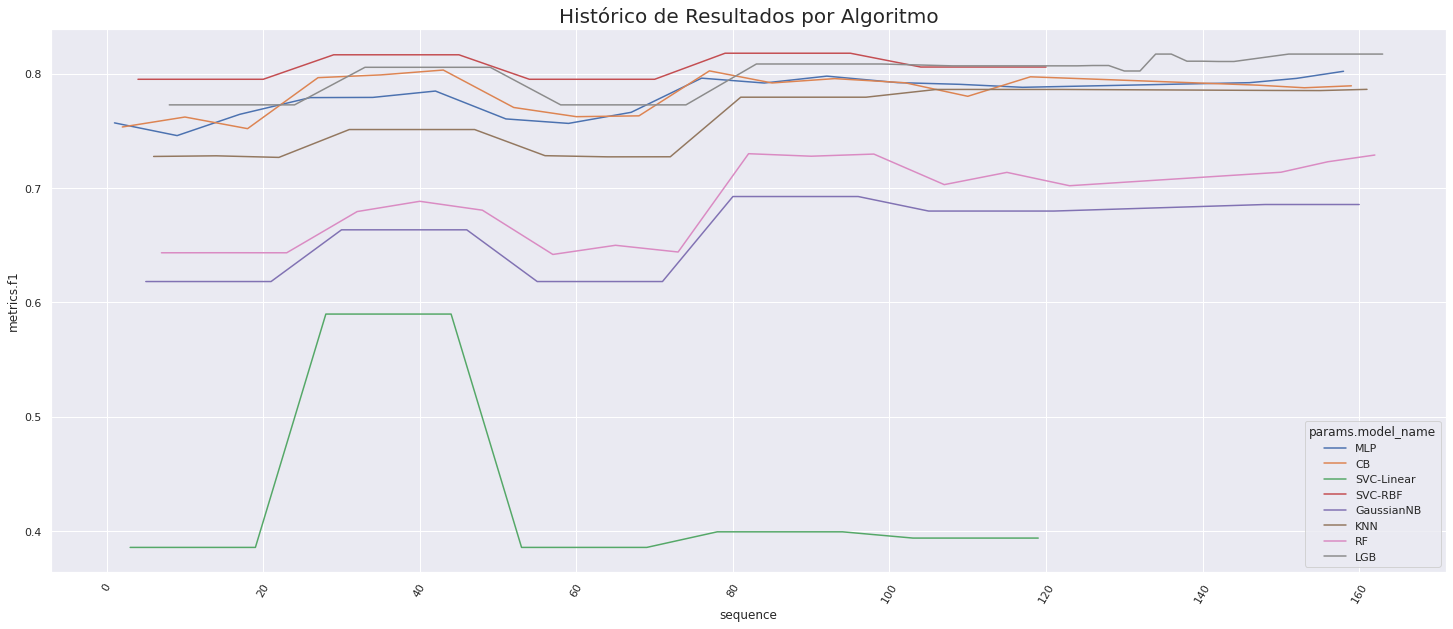

,tags.mlflow.runName,params.model_name,metrics.f1,metrics.precision,metrics.recall,metrics.training_time
68,"01_2_Concat Title and Tags + Weight, Price, and Minimum Quantity_SVC-RBF",SVC-RBF,0.817958,0.862407,0.784987,173.132406
0,01_2_All Models and Text Augmentation: Title and Title + Tags_LGB,LGB,0.817211,0.827651,0.807959,12.854407
27,01_2_Text Augmentation: Title and Title + Tags_LGB,LGB,0.817211,0.827651,0.807959,11.260819
134,"01_0_Complete Set: Title, Concatenated Tags, Weight, Price, and Minimum Quantity_SVC-RBF",SVC-RBF,0.816587,0.863858,0.781765,445.153264
23,01_2_Text Augmentation: Tags and Title + Tags_LGB,LGB,0.810974,0.823762,0.800275,9.582166
19,"01_2_Text Augmentation: Title, Tags and Title + Tags_LGB",LGB,0.810723,0.812009,0.809837,12.379165
35,01_2_Regularize LGB: 250 Iterations_LGB,LGB,0.807200,0.839096,0.781532,12.743577
55,01_0_Concat Title and Tags + Price_LGB,LGB,0.806909,0.844251,0.778679,13.337812
31,01_2_Regularize LGB: 125 Iterations_LGB,LGB,0.802400,0.819479,0.788327,4.854520
159,"01_0_Basic Set: Title, Weight_SVC-RBF",SVC-RBF,0.795154,0.847650,0.761815,205.232014


In [3]:
formated_frame = (best_results
                  .sort_values(by='start_time')
                  .assign(sequence=lambda f:  (f
                                               [['tags.mlflow.parentRunId']]
                                               .groupby('tags.mlflow.parentRunId')
                                               .cumcount()
                                               .reset_index()
                                               .iloc[:, 0]
                                              )
                         )
                 )

g = sns.lineplot(data=formated_frame.loc[lambda f:~f['params.model_name'].isna()], x="sequence", y="metrics.f1", hue="params.model_name")
g.set_title('Histórico de Resultados por Algoritmo', fontdict={'fontsize': 20})
plt.xticks(rotation=60)
plt.show()


columns_to_show = ['tags.mlflow.runName', 'params.model_name',
                   'metrics.f1', 'metrics.precision', 'metrics.recall', 'metrics.training_time',
                   'tags.mlflow.parentRunId', 'run_id',
                  ]

history_frame = (best_results
                 .assign(experiment_name=lambda f: f['experiment_id'].apply(lambda id: mlflow_client.get_experiment(id).name))
                 .sort_values(by='metrics.f1', ascending=False) 
                 .loc[lambda f: ~f['params.model_name'].isna()] 
                 .drop_duplicates(['tags.mlflow.parentRunId'])
                 [columns_to_show]
                 .drop(columns=['tags.mlflow.parentRunId', 'run_id'])
                )
display_side_by_side([history_frame], ['Melhor Resultado de Cada Experimento'])

del formated_frame, history_frame

Como mostram os resultados, foram feitos experimentos combinando diferentes atributos disponíveis. Para a maior parte deles, **o algoritmo SVC-RBF (uma implementação do SVM com kernel RBF) teve a maior parte dos melhores resultados**. **Apesar da boa eficácia do algoritmo, pode-se notar que sua eficiência é pelo menos 12 vezes pior do que a do LightGBM (LGB)**. Apesar de essa comparação não ser perfeitamente justa, considerando o modelo do LGB tem 301 *features* em vez de 303, o experimento com título `01_2_Basic Set: Title, Weight_SVC-RBF` apresenta o mesmo número de *features* e a eficácia do SVC-RBF é ainda pior.

Um ponto interessante de ser notado é que concatenar *título* e *tags* tornou o modelo melhor do que a versão com um *embedding* para cada uma das colunas. Isso é interessante pelo fato de melhorar o resultado e ainda reduzir a utilização de recursos na representação dos dados e no treinamento do modelo. Posteriormente, essa característica foi aproveitada para fazer uma aumentação dos dados. Além de ter os dados de treinamento com o título do produto de modo independente, criou-se uma versão adicional de todos os produtos combinando *título* e *tags*. Como essa versão duplicou a quantidade de dados envolvidos, os modelos menos eficientes, como os baseados no SVM, não foram avaliados.

Considerando a grande diferença de eficiência entre o LGB e o SVC-RBF, faz-se a **escolha do LGB como algoritmo principal**. Apesar de ter uma perda de eficácia, é preciso levar em consideração que no cenário real o volume de dados deveria ser consideravelmente maior e que a implementação do SVM não linear impõe restrições. Assim, a seguir, são recuperados os resultados do LGB em todos os experimentos.

In [4]:
(best_results
 .assign(experiment_name=lambda f: f['experiment_id'].apply(lambda id: mlflow_client.get_experiment(id).name))
 .sort_values(by='metrics.f1', ascending=False) 
 .loc[lambda f: f['params.model_name'] == 'LGB' ]
 .drop_duplicates(['tags.mlflow.parentRunId'])
 [columns_to_show]
)

,tags.mlflow.runName,params.model_name,metrics.f1,metrics.precision,metrics.recall,metrics.training_time,tags.mlflow.parentRunId,run_id
0,01_2_All Models and Text Augmentation: Title and Title + Tags_LGB,LGB,0.817211,0.827651,0.807959,12.854407,5e28446d22a04e919a27d3fb497974fa,1a066c58ad7d4f92ac0c1adfbae31d57
27,01_2_Text Augmentation: Title and Title + Tags_LGB,LGB,0.817211,0.827651,0.807959,11.260819,65152259c7f34a7a9d375319335e1d55,4e8f1d9146974de5b4779a2870c99f38
23,01_2_Text Augmentation: Tags and Title + Tags_LGB,LGB,0.810974,0.823762,0.800275,9.582166,99a3de99f44a4b2d8c817a4d73239403,c126f8dced074cc8a8998504cfd0d876
19,"01_2_Text Augmentation: Title, Tags and Title + Tags_LGB",LGB,0.810723,0.812009,0.809837,12.379165,fe7ca589f7594ed48c663d3fa9ebfab1,0ad55ca227554908be233bd2b8e2c03f
80,"01_0_Concat Title and Tags + Weight, Price, and Minimum Quantity_LGB",LGB,0.808534,0.847163,0.779735,16.645187,7d31ba2aa87f4043b216600ab44d2a3a,2583b7bdff534ce2a8559c610c447306
35,01_2_Regularize LGB: 250 Iterations_LGB,LGB,0.807200,0.839096,0.781532,12.743577,a6f8d6c538e44103a62a595f3594ab4b,fbeac0087ac44629a3a4f5e9be7ef766
55,01_0_Concat Title and Tags + Price_LGB,LGB,0.806909,0.844251,0.778679,13.337812,ec06415edba04014a170e44f491d6cd3,ad4ad8aa0405418fb551d15803e41f09
130,"01_0_Complete Set: Title, Concatenated Tags, Weight, Price, and Minimum Quantity_LGB",LGB,0.805640,0.853343,0.771814,28.760663,8a594d3cc32440edadabfe9cd5c57833,56c50fc320d74a5283945b570188ebcd
31,01_2_Regularize LGB: 125 Iterations_LGB,LGB,0.802400,0.819479,0.788327,4.854520,fe941a78c5374c3db26d3fc7bf4e7341,f8610c74ca1b4cc5bac58219ada4ab7f
147,"01_1_Basic Set: Title, Weight_LGB",LGB,0.772763,0.833968,0.735516,21.732985,f1b9a0390129475c91054cf4dba82146,a0bd8b63edfe4ce38c82ba840889f946


Nos primeiros experimentos, o modelo com melhor resultado teve a concatenação de título e tags, representada por *embeddings*, e três atributos numéricos: *peso*, *preço* e *quantidade mínima*. Como cada *feature* adicional no modelo representa algo a mais a ser mantido e a exigir um trabalho de garantia de qualidade, o modelo mais simples, apenas com preço, é escolhido. Isso também ajuda a minimizar o impacto da ausência dos dados de *peso* e *quantidade minima* na utilização do modelo para a classificação da categoria das buscas.

Posteriormente, com a experimentação com aumentação de dados, foi possível obter o melhor resultado treinando o modelo usando apenas título e preço e criando uma versão alternativa de cada produto com a concatenação de título e tags, além do preço. Com isso, pôde-se ter uma aproximação grande dos resultados do SVC-RBF, mas com um tempo de treinamento 13.5 vezes menor. 

## Restauração de Experimentos

A partir da escolha de uma execução individual, é possível restaurar os elementos utilizados na experimentação para aplicá-los aos dados.

In [5]:
# Restaura o experimento pelo maior valor de F1 Médio (entre as classes)
best_experiments_results = mlflow.search_runs(experiment_ids=[EXPERIMENT_ID], max_results=100, order_by=['metrics.f1 DESC'], filter_string='attributes.status="FINISHED"')
best_experiment = (best_experiments_results
 .loc[lambda f: f['run_id'] == '1a066c58ad7d4f92ac0c1adfbae31d57']
 .iloc[0]
)

# Recupera o ID do artefato para recuperar modelos e recursos persistidos para o experimento
artifact_uri = best_experiment["artifact_uri"]

# Mostra as principais informações da execução
display(HTML('<h4>Resultado Escolhido:</h4>'))
for name, key in [('Run ID', 'run_id'),
                  ('Model Name', 'params.model_name'),
                  ('Average F1', 'metrics.f1'),
                  ('Average Precision', 'metrics.precision'),
                  ('Average Recall', 'metrics.recall'),
                  ('Experiment Run', 'tags.mlflow.runName'),
                 ]:
    display(HTML(f'<li><strong>{name}</strong>: {best_experiment[key]}</li>'))

# Recupera o pacote de funções e parâmetros de pré-processamento dos dados


preprocessing_model_path = str(Path(best_experiment['artifact_uri']
                                    .replace(best_experiment['run_id'],
                                             best_experiment['tags.mlflow.parentRunId'])).joinpath('log',
                                                                                                   'preprocessing_model'))
preprocessing_model = mlflow.pyfunc.load_model(preprocessing_model_path)

# Recupera o modelo treinado
model = mlflow.sklearn.load_model(f'{artifact_uri}/model')

# Recupera o Label Encoder, caso seja preciso avaliar o modelo
label_encoder_path = str(Path(best_experiment['artifact_uri']
                              .replace(best_experiment['run_id'],
                                       best_experiment['tags.mlflow.parentRunId'])).joinpath('label_encoder'))
label_encoder_model = mlflow.sklearn.load_model(label_encoder_path)

Para validar o funcionamento da restauração do modelo, parte dos dados de treinamento são recuperados para uma avaliação.

In [6]:
columns_to_read = ['product_id', 'title', 'concatenated_tags', 'price', 'weight', 'express_delivery', 'minimum_quantity', 'category', 'creation_date']
frame = (pd
         .read_csv(str(Path(settings.DATA_PATH).joinpath('interim', 'training.csv')), usecols=columns_to_read)
         .drop_duplicates()  # Manter mais de uma ocorrência de produto apenas se existir variação nos dados
        )
print(f'Registros carregados: {len(frame)}')

Registros carregados: 32729


Tendo os dados, é possível reprocessar *labels*, *features* e fazer a inferência.

In [7]:
sample_frame = (frame
                .drop_duplicates('category')
                .sort_values(by='category')
               )

# Processa os dados para inferência
features = preprocessing_model.predict(sample_frame)

# Realiza a inferência
sample_frame['pred'] = model.predict(features)

# Codificar labels
sample_frame['label'] = label_encoder_model.transform(sample_frame.category)

display_side_by_side([sample_frame, 
                      pd.DataFrame(features).describe().T.head(10)], 
                     ['Dados Recuperados e Predição', 
                      f'Features (10 de {features.shape[1]})'])

del sample_frame, features

## Análise dos Resultados

Nesta seção faz-se a análise mais aprofundada dos resultados do modelo escolhido. O primeiro passo é restaurar os dados utilizados para criar e validadr os modelos preliminares criados no *notebook* [Classificação de Categorias](03.0_Classificacao_de_Categorias.ipynb). O pré-processamento dos dados pode ser feito antes mesmo da divisão porque os parâmetros do pré-processamento foram feitos com os dados de treinamento, conforme o *notebook* indicado.

In [8]:
ENCODING_SORTED_LABELS = [label_encoder_model.inverse_transform([item])[0]
                          for item in range(0, 6)]

# Pré-processa e faz predições
features = preprocessing_model.predict(frame)

frame['pred'] = model.predict(features)
frame['label'] = label_encoder_model.transform(frame.category)

# Cria coluna com as probabilidades de cada item pertencer a uma categoria
class_prob_frame = pd.DataFrame(model.predict_proba(features), 
                                columns=[f'Prob_{item.replace(" ", "_")}' 
                                         for item in ENCODING_SORTED_LABELS])

# Atribui as colunas ao data frame (concatenar causa mudança de tipos)
for column in class_prob_frame.columns:
    frame[column] = class_prob_frame[column].apply(lambda x: f'{x * 100:.2f}%').to_numpy()

# Separa os conjuntos de treinamento e validação
cut_off_period = '2018-05'
split_frame = set_dataset_split(frame, cut_off_period)

training_frame = split_frame.loc[lambda f: f['group'] != 'test'].drop(columns=['group'])
validation_frame = split_frame.loc[lambda f: f['group'] == 'test'].drop(columns=['group'])

del class_prob_frame

A seguir, as predições de treinamento e validação são usadas para avaliar o comportamento do modelo selecionado, tanto nos dados completos, quanto por cada categoria.

In [9]:
# Calcular métricas para treinamento e validação
metrics = [
    {**{'dataset': 'training'}, **compute_multiclass_classification_metrics(training_frame['label'], training_frame['pred'])},
    {**{'dataset': 'validation'}, **compute_multiclass_classification_metrics(validation_frame['label'], validation_frame['pred'])}
]

# Calcular a média das métricas entre as categorias (não proporcional ao número de elementos)
metrics_frame = (pd.DataFrame(metrics)
                 .assign(precision=lambda f: f['precision'].apply(lambda v: np.mean(v, axis=0)))
                 .assign(recall=lambda f: f['recall'].apply(lambda v: np.mean(v, axis=0)))
                 .assign(f1=lambda f: f['f1'].apply(lambda v: np.mean(v, axis=0)))
                )

individual_metrics_frame = (pd.DataFrame([metrics[1]])
                            [['precision', 'recall', 'f1']]
                            .T)

individual_metrics_frame = (pd
                            .DataFrame(np.stack(individual_metrics_frame[0], axis=0), 
                                       columns=ENCODING_SORTED_LABELS)
                            .T
                            .rename(columns={ix: name
                                            for ix, name in enumerate(['precision', 'recall', 'f1'])})
                            .reset_index()
                            .rename(columns={'index': 'category'})
                            .sort_values(by='category')
                           )

# Calcular a distribuição dos registros por classe
distribution_frame = (training_frame
                      [['category']]
                      .assign(registros=1)
                      .groupby('category')
                      .sum()
                      .reset_index()
                      .sort_values(by='category')
                      .assign(percentual=lambda f: (100 * f['registros'] / f['registros'].sum()).apply(lambda v: f'{v:.2f}%'))
                     )


# Exibir resultados
display_side_by_side([metrics_frame, individual_metrics_frame, distribution_frame],
                     ['Métricas Gerais de Treinamento e Validação', 'Métricas de Validação por Classes', 'Distribuição de Registros por Classes no Treinamento'],
                     padding=50
                    )

del metrics, metrics_frame, individual_metrics_frame, distribution_frame

Como é possível notar, o modelo praticamente acertou todos os casos do conjunto de treinamento, com .99 de F1, mas caiu para .81 nos dados de teste. Isso levanta a possibilidade que de alguma forma de regularização -- além do número de iterações, que já foi reduzido pelo mesmo motivo -- possa ser aplicada para simplificar o modelo e permitir uma generalização maior do que foi aprendido.

Com relação às classes, há uma perda maior de eficácia na classificação de duas delas: `Outros`  e `Papel e Cia`. Para ajudar a entender melhor o que ocorre, pode-se analisar a matriz de confusão.

In [10]:
display_side_by_side([pd
                      .DataFrame(confusion_matrix(validation_frame['label'], validation_frame['pred']), columns=ENCODING_SORTED_LABELS)
                      .rename(index={i: ENCODING_SORTED_LABELS[i] for i in range(0, 6)})
                     ],
                     ['Matriz de Confusão']
                    )

,Bebê,Bijuterias e Jóias,Decoração,Lembrancinhas,Outros,Papel e Cia
Bebê,878,1,34,103,5,13
Bijuterias e Jóias,0,94,3,6,1,0
Decoração,33,1,977,69,10,13
Lembrancinhas,85,3,73,2572,9,99
Outros,4,2,16,28,113,6
Papel e Cia,7,0,9,101,10,221


Considerando que as linhas são os valores dos rótulos (verdadeiros) e as colunas indicam as predições, é possível notar que `Outros` e `Papel e Cia` são incorretamente classificadas mais frequentemente com  `Lembrancinhas`, que é uma categoria com certa ambiguidade e que possui a maior quantidade de registros no conjunto de dados, responsável por 45% do treinamento. Essa predominância da classe, no entanto, é contornada com o balanceamento dos pesos no momento do treinamento. 

A seguir, são coletados alguns casos de classificação incorreta para entender o que está sendo confundido.

In [11]:
def get_classification_examples(base_frame: pd.DataFrame, label: str, prediction: str, size=15) -> pd.DataFrame:
    encoded_label = label_encoder_model.transform([label])[0]
    encoded_prediction = label_encoder_model.transform([prediction])[0]

    return (base_frame
            .loc[lambda f: (f['label'] == encoded_label) & (f['pred'] == encoded_prediction)]
            .head(size)
           )

display_side_by_side([get_classification_examples(validation_frame, 'Papel e Cia', 'Lembrancinhas')], 
                     ['Exemplos de produtos de <strong>Papel e Cia</strong> incorretamente classificados como <strong>Lembrancinhas</strong>'])

,product_id,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,category,pred,label,Prob_Bebê,Prob_Bijuterias_e_Jóias,Prob_Decoração,Prob_Lembrancinhas,Prob_Outros,Prob_Papel_e_Cia,period
109,8336279,Topper - Elefantinho chevron chá de revelação,topper cha revelacao,2018-06-18 18:19:28,10.670000,3.0,1,40,Papel e Cia,3,5,20.89%,0.00%,3.40%,62.84%,0.13%,12.74%,2018-06
446,9846073,caixinha para lembrancinha - sacolinha aniversário 80 anos,aniver vo 90 anos 90 anos festa vo caixas sacolinha bolsinhas,2018-06-11 09:31:12,11.540000,0.0,1,15,Papel e Cia,3,5,0.07%,0.00%,0.05%,99.28%,0.04%,0.55%,2018-06
578,9072281,Caixa para cerveja dia dos Pais,dia pais,2018-07-12 22:25:40,20.260000,7.0,1,5,Papel e Cia,3,5,0.54%,0.00%,0.94%,64.95%,0.19%,33.37%,2018-07
666,11511720,Senha individual - Convite individual,casamento formatura aniversario casamento noivado,2018-08-21 14:39:14,10.500000,8.0,1,34,Papel e Cia,3,5,0.20%,0.00%,3.68%,76.66%,0.06%,19.40%,2018-08
1076,9432165,PORTA BOMBOM CAMISA - DIA DOS PAIS,dia pais,2018-06-23 22:49:23,9.780000,0.0,1,20,Papel e Cia,3,5,0.76%,0.00%,0.89%,96.57%,0.38%,1.39%,2018-06
1799,13564556,Caixa 4 bombons c/tampa,caixinha casamento caixinha bombom lembrancinha convidados q n vao,2018-06-16 16:53:24,10.710000,20.0,1,50,Papel e Cia,3,5,0.18%,0.00%,0.06%,94.30%,0.04%,5.43%,2018-06
1837,9364413,Caixa para 6 doces Melhores Amigos C/10 un,caixa 6 brigadeiros,2018-08-15 17:46:45,25.350000,188.0,1,1,Papel e Cia,3,5,0.71%,0.00%,23.94%,44.67%,0.66%,30.01%,2018-08
2249,14327291,Aplique LOL,l.o.l lol manu 5 anos,2018-07-14 14:21:28,11.100000,0.0,1,20,Papel e Cia,3,5,1.02%,0.00%,13.97%,81.03%,0.53%,3.44%,2018-07
2396,9072281,Caixa para cerveja dia dos Pais,dia pais,2018-07-12 22:25:40,21.090000,6.0,1,12,Papel e Cia,3,5,0.54%,0.00%,0.94%,64.95%,0.19%,33.37%,2018-07
2460,3605026,Caixa Milk com Scrap Turma da Mõnica,precos bons turma monica lucas 6 anos niver ingride festa v festa monica aniversario sofia monica lembrancas turma monica sophia turma monica,2018-06-16 22:18:23,13.430000,20.0,1,15,Papel e Cia,3,5,0.06%,0.00%,0.27%,99.04%,0.00%,0.63%,2018-06


A seguir, faz-se a análise dos resultados considerando a probabilidade dada pelo modelo para cada classe. Ainda que se saiba que as probabilidades devessem ser calibradas para refletir melhor esse conceito, elas serão levadas em consideração para entender como o modelo determina os resultados.

A julgar pelos exemplos exibidos, o título dos produtos em sua grande maioria podem ser considerados ambíguos ou ambivalência, podendo ser encaixados em diferentes categorias. Essa características, que pode chegar a ser vista como polivalência, pode ser notada na forma como o modelo escolhido define as probabilidades, como no caso de `Topper - Elefantinho chevron chá de revelação`. Esse produto tem o rótulo "Papel e Cia", que recebeu probabilidade de 12.7%, teve predição como "Lembrancinhas", com 62.8% de probabilidade. A categoria mais provável, por um olhar leigo e superficial, não parece ser um erro claro e poderia ser aceita como uma classificação correta.

Outro exemplo dessa ambivalência pode ser notada para o produto `Caderno Personalizado Dia dos Pais`. O produto recebe as probabilidades de 51.98% e 46.89%, respectivamente, para "Lembrancinhas" e "Papel e Cia". Novamente, a julgar pelo título e pela descrição, o produto pode ser vendido em uma seção de papelaria, mas ao mesmo tempo tem características adequadas para servir de lembrança de uma data comemorativa.

Pelos exemplos avaliados, ainda que se possa trabalhar na utilização de mais *features*, fazer a aumentação de dados ou tentar ajustar o *threshold* das classes, parece existir um problema maior que é inerente aos dados: a ambiguidade ou polivalência dos produtos. Nesse sentido, poderia fazer mais sentido avaliar a qualidade com relação a *soft-labels* em vez de um único *hard-label*. 

In [12]:
display_side_by_side([get_classification_examples(validation_frame, 'Outros', 'Lembrancinhas')], 
                     ['Exemplos de produtos de <strong>Outros</strong> incorretamente classificados como <strong>Lembrancinha</strong>'])

,product_id,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,category,pred,label,Prob_Bebê,Prob_Bijuterias_e_Jóias,Prob_Decoração,Prob_Lembrancinhas,Prob_Outros,Prob_Papel_e_Cia,period
2394,8753842,Kit Camiseta Chá Bar,cha cha bar,2018-06-05 14:37:26,67.94,6.0,1,1,Outros,3,4,0.89%,0.00%,0.84%,98.00%,0.05%,0.22%,2018-06
3093,11356309,Lembrancinha Dia dos Pais,dia pais,2018-06-03 16:20:45,15.56,5.0,1,1,Outros,3,4,0.19%,0.00%,0.04%,99.74%,0.01%,0.02%,2018-06
3272,865802,sabonete camomila,sabonetes lembrancinhas,2018-08-02 16:24:30,14.11,6.0,1,5,Outros,3,4,2.20%,0.00%,0.89%,91.65%,5.24%,0.02%,2018-08
3344,6414970,Aplique Bigode,dia pais,2018-07-09 10:07:05,9.49,9.0,1,100,Outros,3,4,5.70%,0.00%,13.74%,65.96%,0.81%,13.79%,2018-07
3696,7170633,Lembrancinha Dia dos Pais,dia pais,2018-06-04 15:28:53,15.38,5.0,1,5,Outros,3,4,0.19%,0.00%,0.04%,99.74%,0.01%,0.02%,2018-06
4457,3711214,FRETE GRATIS Kit Atividade Educacional Montessori brinquedo,hastes coloridas atividades ludicas pompons acrilicos escola,2018-08-28 12:41:44,75.43,0.0,0,10,Outros,3,4,7.83%,0.00%,31.42%,38.62%,6.45%,15.67%,2018-08
5632,3645138,SABONETE FLOR DE CEREJEIRA,kokeshi,2018-06-21 14:37:23,40.98,135.0,1,10,Outros,3,4,1.97%,0.00%,18.89%,71.42%,7.56%,0.15%,2018-06
6767,9197447,Pompom Pacote 400 Unidades Mini Pompons 10 mm Artesanato,lacos arcos marcas famosas unicornios loja henrikei artes pompons lol surpresa apliques,2018-07-27 12:21:48,32.80,6.0,0,4,Outros,3,4,5.05%,0.01%,5.90%,48.32%,30.00%,10.71%,2018-07
6920,13061534,Saquinho de juta 11 x 8,saco juta casamento a&r embalagem presentes casamento saquinho juta saquinho saquinhos juta sacos juta,2018-08-18 18:21:20,0.99,21.0,1,40,Outros,3,4,9.73%,0.00%,9.36%,44.51%,14.45%,21.95%,2018-08
8310,2278516,Kit Masculino Pais/Padrinhos/Presente,presentes lembrancas casamento masculinos,2018-07-16 10:22:36,45.32,0.0,1,11,Outros,3,4,2.76%,0.01%,1.09%,92.60%,1.66%,1.87%,2018-07


Para a categoria "Outros", que deve enquadrar produtos variados que não se encaixam nas demais categorias, o modelo apresentou menos certeza, considerando o valor máximo das probabilidades. Pode-se notar uma certeza grande, de 99.74%, na classe "Lembrancinhas" para o produto `Lembrancinha Dia dos Pais`, que leva o nome da categoria em seu nome e pode servir de indício de dados que poderiam ser corrigidos. Há, também, situações mais duvidosas, como a de `Bico De Pato Importado Ponta Especial 5,5 Cm - 50 Peças`, que teve a probabilidade distribuída entre diversas categorias e teve seu maior valor em 27.92%.
 
Considerando  que "Outros" pode ter muita diversidade de conteúdo, é de se entender que o modelo veja mais semelhança entre produtos de outras categorias que estão relacionados a festividades e presentes.

A respeito dos possíveis dados que poderiam ser corrigidos, é provável que seja algo relacionado às dificuldades inerentes ao Elo7 e às formas de classificação de produtos no momento em que o conjunto de dados foi gerado.